In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pathlib

from tensorflow import keras
from keras import layers

In [3]:
# Get dataset paths
ds_path = pathlib.Path('..', 'dataset')

train_path = pathlib.Path(ds_path, 'train')
test_path = pathlib.Path(ds_path, 'test')
validation_path = pathlib.Path(ds_path, 'validation')

print(train_path, test_path, validation_path)

..\dataset\train ..\dataset\test ..\dataset\validation


In [4]:
# Specify batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [5]:
# Create train dataset from directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

# Create validation dataset from directory
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_path,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

# Create test dataset from directory
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 4000 files belonging to 4 classes.
Found 800 files belonging to 4 classes.
Found 800 files belonging to 4 classes.


In [6]:
# Get all vegetables (classes)
class_names = train_dataset.class_names
print(class_names)

['Bean', 'Broccoli', 'Carrot', 'Tomato']


In [7]:
# Use buffered prefetching to load the images from disk without I/O become blocking
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
# Create a data augmentation layer to use in our new 'transfer-learned' model
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
  ]
)

In [9]:
# Create a rescaling layer to preprocess input, since MobileNetV2 expects pixel values between [-1, 1]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [12]:
# Freeze the convolutional base of MobileNetV2 model
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [13]:
# Create layer to convert features to to a single 1280-element vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [14]:
# Create layer to convert these features into a single prediction
prediction_layer = layers.Dense(128, activation='relu')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 128)


In [15]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [18]:
len(model.trainable_variables)

2

In [19]:
epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

25/25 [==============================] - 6s 166ms/step - loss: 5.0872 - accuracy: 0.0012


In [20]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/10
125/125 [==============================] - 31s 227ms/step - loss: 2.9272 - accuracy: 0.3543 - val_loss: 1.4814 - val_accuracy: 0.7387
Epoch 2/10
125/125 [==============================] - 26s 211ms/step - loss: 0.9047 - accuracy: 0.8347 - val_loss: 0.5587 - val_accuracy: 0.9638
Epoch 3/10
125/125 [==============================] - 27s 214ms/step - loss: 0.4125 - accuracy: 0.9500 - val_loss: 0.2822 - val_accuracy: 0.9887
Epoch 4/10
125/125 [==============================] - 27s 216ms/step - loss: 0.2432 - accuracy: 0.9735 - val_loss: 0.1717 - val_accuracy: 0.9937
Epoch 5/10
125/125 [==============================] - 27s 219ms/step - loss: 0.1807 - accuracy: 0.9740 - val_loss: 0.1173 - val_accuracy: 0.9987
Epoch 6/10
125/125 [==============================] - 28s 222ms/step - loss: 0.1238 - accuracy: 0.9837 - val_loss: 0.0859 - val_accuracy: 0.9987
Epoch 7/10
125/125 [==============================] - 28s 223ms/step - loss: 0.1074 - accuracy: 0.9837 - val_loss: 0.0666 - val_ac

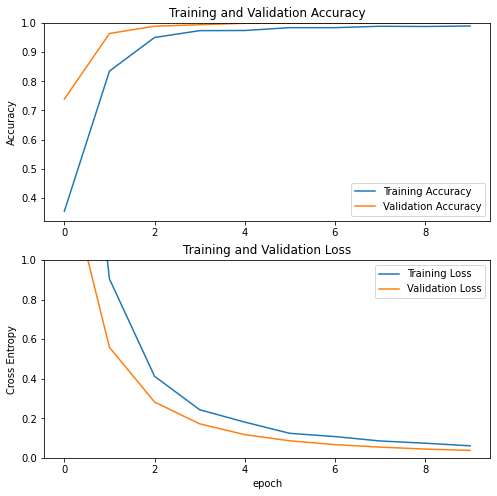

In [21]:
def visualize_stats():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [25]:
# Fine-tuning the model

base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [26]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [27]:
len(model.trainable_variables)

56

In [28]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
125/125 [==============================] - 37s 276ms/step - loss: 0.0206 - accuracy: 0.9935 - val_loss: 0.0032 - val_accuracy: 0.9987
Epoch 11/20
125/125 [==============================] - 34s 274ms/step - loss: 0.0065 - accuracy: 0.9977 - val_loss: 4.1646e-04 - val_accuracy: 1.0000
Epoch 12/20
125/125 [==============================] - 35s 282ms/step - loss: 0.0047 - accuracy: 0.9990 - val_loss: 3.3052e-04 - val_accuracy: 1.0000
Epoch 13/20
125/125 [==============================] - 36s 287ms/step - loss: 0.0030 - accuracy: 0.9985 - val_loss: 3.6885e-04 - val_accuracy: 1.0000
Epoch 14/20
125/125 [==============================] - 35s 282ms/step - loss: 0.0022 - accuracy: 0.9992 - val_loss: 1.1904e-04 - val_accuracy: 1.0000
Epoch 15/20
125/125 [==============================] - 36s 287ms/step - loss: 4.9775e-04 - accuracy: 1.0000 - val_loss: 1.7279e-05 - val_accuracy: 1.0000
Epoch 16/20
125/125 [==============================] - 36s 290ms/step - loss: 3.8377e-04 - accuracy:

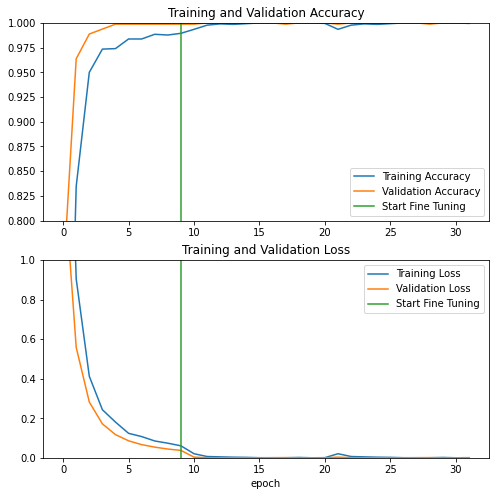

In [30]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()